In [1]:
!unzip -q ./picture.zip

In [40]:
import os, glob, random, shutil
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import torch.nn as nn
import json
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches

In [41]:
image_dir = '/content/Sample/01.원천데이터'
label_dir = '/content/Sample/02.라벨링데이터'

In [42]:
train_root = f'./train'
valid_root = f'./valid'
test_root = f'./test'

In [43]:
for folder in [train_root, valid_root, test_root]:
    for s in ['images', 'labels']:
        os.makedirs(f'{folder}/{s}', exist_ok=True)

json_files = glob.glob(os.path.join(label_dir, "*/*.json"))
print("총 라벨 파일 수:", len(json_files))
json_files

총 라벨 파일 수: 560


['/content/Sample/02.라벨링데이터/나무/나무_10_남_05081.json',
 '/content/Sample/02.라벨링데이터/나무/나무_9_남_06263.json',
 '/content/Sample/02.라벨링데이터/나무/나무_9_남_00284.json',
 '/content/Sample/02.라벨링데이터/나무/나무_11_남_03861.json',
 '/content/Sample/02.라벨링데이터/나무/나무_12_남_07438.json',
 '/content/Sample/02.라벨링데이터/나무/나무_10_남_07104.json',
 '/content/Sample/02.라벨링데이터/나무/나무_12_남_07670.json',
 '/content/Sample/02.라벨링데이터/나무/나무_10_남_11353.json',
 '/content/Sample/02.라벨링데이터/나무/나무_11_남_08645.json',
 '/content/Sample/02.라벨링데이터/나무/나무_12_여_13382.json',
 '/content/Sample/02.라벨링데이터/나무/나무_9_남_03417.json',
 '/content/Sample/02.라벨링데이터/나무/나무_13_남_13962.json',
 '/content/Sample/02.라벨링데이터/나무/나무_8_남_08800.json',
 '/content/Sample/02.라벨링데이터/나무/나무_8_남_11764.json',
 '/content/Sample/02.라벨링데이터/나무/나무_10_남_11234.json',
 '/content/Sample/02.라벨링데이터/나무/나무_12_남_03152.json',
 '/content/Sample/02.라벨링데이터/나무/나무_10_여_12730.json',
 '/content/Sample/02.라벨링데이터/나무/나무_11_여_09853.json',
 '/content/Sample/02.라벨링데이터/나무/나무_10_여_01571.json',
 '/content/Sample

In [44]:
random.seed(2025)
random.shuffle(json_files)
test_ratio, valid_ratio = 0.1, 0.1
num_file = len(json_files)

test_list  = json_files[:int(num_file * test_ratio)]
valid_list = json_files[int(num_file * test_ratio):int(num_file * (test_ratio+valid_ratio))]
train_list = json_files[int(num_file * (test_ratio+valid_ratio)):]

In [45]:
splits = {
    'train': train_list,
    'valid': valid_list,
    'test':  test_list
}

In [46]:
classes = ["나무", "남자사람", "여자사람", "집"]
class2idx = {c:i for i,c in enumerate(classes)}

In [48]:
for split, file_list in splits.items():
    split_root = f'./{split}'
    print(f"\nProcessing {split}...")

    for json_path in tqdm(file_list):
        # 파일 이름, 클래스 이름
        file_name = os.path.basename(json_path)
        class_name = os.path.basename(os.path.dirname(json_path))
        base_name = os.path.splitext(file_name)[0]

        # 이미지 복사
        img_path = os.path.join(image_dir, class_name, base_name + '.jpg')
        if os.path.exists(img_path):
            shutil.copy(img_path, f'{split_root}/images/{base_name}.jpg')
        else:
            print(f"이미지 없음: {img_path}")
            continue  # 이미지 없으면 건너뜀

        # txt 변환

        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        img = Image.open(img_path)
        W, H = img.size

        lines = []
        for bbox in data["annotations"]["bbox"]:
            cls_name = data["annotations"]["class"]
            cls = class2idx[cls_name]
            x_center = (bbox["x"] + bbox["w"]/2) / W
            y_center = (bbox["y"] + bbox["h"]/2) / H
            w_norm = bbox["w"] / W
            h_norm = bbox["h"] / H
            lines.append(f"{cls} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")

        # txt 저장
        txt_save_path = os.path.join(split_root, "labels", base_name + ".txt")
        with open(txt_save_path, "w", encoding="utf-8") as f:
            f.write("\n".join(lines))

        # json도 같이 복사
        json_save_path = os.path.join(split_root, "labels", base_name + ".json")
        shutil.copy(json_path, json_save_path)


Processing train...


100%|██████████| 448/448 [00:00<00:00, 1102.33it/s]



Processing valid...


100%|██████████| 56/56 [00:00<00:00, 1092.21it/s]



Processing test...


100%|██████████| 56/56 [00:00<00:00, 1113.43it/s]


In [49]:
class YoloDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, S=7, B=2, C=4, transform=None):
        self.img_paths = glob.glob(os.path.join(image_dir, "*/*.jpg"))
        self.ann_paths = glob.glob(os.path.join(label_dir, "*/*.txt"))
        self.S, self.B, self.C = S, B, C
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # target tensor (S,S,C+5*B)
        target = torch.zeros((self.S, self.S, self.C + 5*self.B))

        # 라벨 파일 경로 매핑
        txt_path = img_path.replace("images","labels").replace(".jpg",".txt")

        if os.path.exists(txt_path):
            with open(txt_path,"r",encoding="utf-8") as f:
                for line in f.readlines():
                    cls, xc, yc, w, h = map(float,line.strip().split())
                    cls = int(cls)

                    i = int(xc * self.S)
                    j = int(yc * self.S)
                    i = min(max(i,0), self.S-1)
                    j = min(max(j,0), self.S-1)

                    # B=2 처리: 빈 슬롯 찾기
                    for b in range(self.B):
                        conf_idx = self.C + 5*b + 4
                        if target[j,i,conf_idx] == 0:  # conf가 0이면 빈 슬롯
                            target[j,i,cls] = 1
                            target[j,i,self.C+5*b:self.C+5*b+5] = torch.tensor([xc,yc,w,h,1])
                            break

        return img, target

In [50]:
class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=len(classes)):
        super().__init__()
        self.S, self.B, self.C = S,B,C
        self.conv = nn.Sequential(
            nn.Conv2d(3,16,3,2,1), nn.ReLU(),
            nn.Conv2d(16,32,3,2,1), nn.ReLU(),
            nn.Conv2d(32,64,3,2,1), nn.ReLU(),
            nn.Conv2d(64,128,3,2,1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((S,S))
        )
        # 출력: (S,S,5B+C)
        self.fc = nn.Conv2d(128, 5*B+C, 1)
    def forward(self,x):
        x = self.conv(x)
        x = self.fc(x)        # (N, 5B+C, S, S)
        return x.permute(0,2,3,1)  # (N,S,S,5B+C)

# 데이터 불러오기
transform = T.Compose([T.Resize((224,224)), T.ToTensor()])

train_dataset = YoloDataset(
    image_dir,
    label_dir,
    S=7,
    B=2,
    C=4,
    transform=transform
)

valid_dataset = YoloDataset(
    image_dir,
    label_dir,
    S=7,
    B=2,
    C=4,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)


In [51]:
class YOLOv1Loss(nn.Module):
    def __init__(self, S=7, B=2, C=4, λ_coord=5, λ_noobj=0.5):
        super().__init__()
        self.S, self.B, self.C = S, B, C
        self.λ_coord = λ_coord
        self.λ_noobj = λ_noobj
        self.mse = nn.MSELoss(reduction="sum")

    def forward(self, preds, targets):
        """
        preds:   (N, S, S, 5B + C)   = [..., (x,y,w,h,conf)*B , class*C]
        targets: (N, S, S, 5B + C)   = 동일 포맷 (셀 원핫 + B개 박스)
        """
        N = preds.size(0)

        # 분해
        pred_box   = preds[..., :5*self.B].view(N, self.S, self.S, self.B, 5)     # (N,S,S,B,5)
        pred_cls   = preds[..., 5*self.B:]                                        # (N,S,S,C)

        target_box = targets[..., :5*self.B].view(N, self.S, self.S, self.B, 5)   # (N,S,S,B,5)
        target_cls = targets[..., 5*self.B:]                                      # (N,S,S,C)

        # 마스크
        obj_mask_B    = (target_box[..., 4] > 0).float()            # (N,S,S,B)
        obj_mask_cell = (obj_mask_B.any(dim=3)).float().unsqueeze(-1)  # (N,S,S,1)

        # 좌표 손실 (λ_coord)
        coord_mask = obj_mask_B.unsqueeze(-1)                        # (N,S,S,B,1)
        xy_loss = self.mse(coord_mask * pred_box[..., 0:2],
                           coord_mask * target_box[..., 0:2])
        wh_loss = self.mse(coord_mask * torch.sqrt(pred_box[..., 2:4].abs() + 1e-6),
                           coord_mask * torch.sqrt(target_box[..., 2:4].clamp_min(1e-6)))
        coord_loss = self.λ_coord * (xy_loss + wh_loss)

        # confidence 손실
        obj_loss    = self.mse(obj_mask_B * pred_box[..., 4],  obj_mask_B * target_box[..., 4])
        noobj_loss  = self.mse((1 - obj_mask_B) * pred_box[..., 4], (1 - obj_mask_B) * 0.0)
        noobj_loss *= self.λ_noobj

        # 클래스 손실 (셀 단위)
        class_loss = self.mse(obj_mask_cell * pred_cls, obj_mask_cell * target_cls)

        loss = (coord_loss + obj_loss + noobj_loss + class_loss) / N
        return loss

[Epoch 1] Train Loss: 0.0006, Train IoU: 0.0000 | Valid Loss: 0.0000, Valid IoU: 0.0000
[Epoch 2] Train Loss: 0.0000, Train IoU: 0.0000 | Valid Loss: 0.0000, Valid IoU: 0.0000
[Epoch 3] Train Loss: 0.0000, Train IoU: 0.0000 | Valid Loss: 0.0000, Valid IoU: 0.0000
[Epoch 4] Train Loss: 0.0000, Train IoU: 0.0000 | Valid Loss: 0.0000, Valid IoU: 0.0000
[Epoch 5] Train Loss: 0.0000, Train IoU: 0.0000 | Valid Loss: 0.0000, Valid IoU: 0.0000
[Epoch 6] Train Loss: 0.0000, Train IoU: 0.0000 | Valid Loss: 0.0000, Valid IoU: 0.0000
[Epoch 7] Train Loss: 0.0000, Train IoU: 0.0000 | Valid Loss: 0.0000, Valid IoU: 0.0000
[Epoch 8] Train Loss: 0.0000, Train IoU: 0.0000 | Valid Loss: 0.0000, Valid IoU: 0.0000
[Epoch 9] Train Loss: 0.0000, Train IoU: 0.0000 | Valid Loss: 0.0000, Valid IoU: 0.0000
[Epoch 10] Train Loss: 0.0000, Train IoU: 0.0000 | Valid Loss: 0.0000, Valid IoU: 0.0000


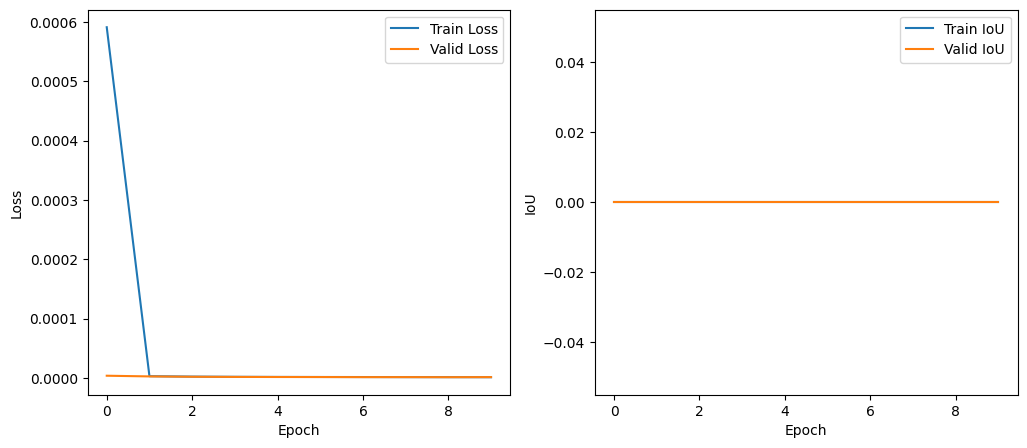

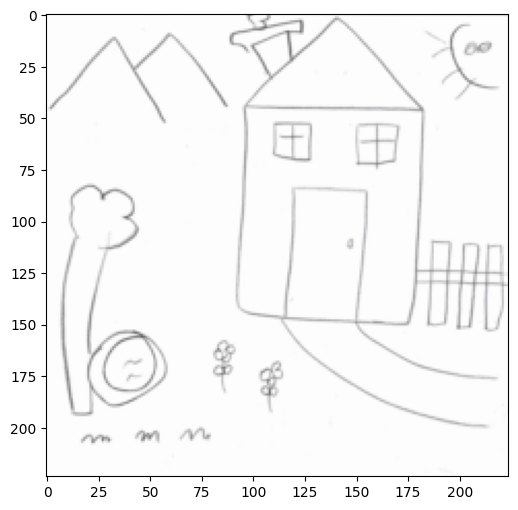

In [52]:
B = 2
train_losses, valid_losses = [], []
train_ious, valid_ious = [], []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLOv1().to(device)
criterion = YOLOv1Loss(S=7, B=B, C=len(classes)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss, total_iou = 0, 0
    for imgs, targets in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)

        loss = criterion(preds, targets)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()

        # IoU 계산 (B=2 대응)
        # ... 학습 루프 내부에서 누적 지표 계산 부분만 교체 ...
        # pred conf>0.5 여부 (N,S,S,B)
        pred_obj = (preds[..., 4:4*model.B:5] > 0.5)
        true_obj = (targets[..., 4:4*model.B:5] > 0)

        # B축 any → (N,S,S)
        pred_any = pred_obj.any(dim=-1)
        true_any = true_obj.any(dim=-1)

        total_iou += (pred_any & true_any).float().mean().item()

    avg_train_loss = total_loss / len(train_loader)
    avg_train_iou = total_iou / len(train_loader)
    train_losses.append(avg_train_loss)
    train_ious.append(avg_train_iou)

    model.eval()
    val_loss, val_iou = 0, 0
    with torch.no_grad():
        for imgs, targets in valid_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            loss = criterion(preds, targets)
            val_loss += loss.item()

            pred_boxes = (preds[..., 4:5*B:5] > 0.5).float()
            true_boxes = (targets[..., 4:5*B:5] > 0.5).float()
            val_iou += (pred_boxes * true_boxes).mean().item()

    avg_val_loss = val_loss / len(valid_loader)
    avg_val_iou = val_iou / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_ious.append(avg_val_iou)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f} | "
          f"Valid Loss: {avg_val_loss:.4f}, Valid IoU: {avg_val_iou:.4f}")

# 그래프
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_ious, label="Train IoU")
plt.plot(valid_ious, label="Valid IoU")
plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.legend()
plt.show()

# 검증 이미지 시각화
sample_idx = random.randint(0, len(valid_dataset)-1)
img, target = valid_dataset[sample_idx]
model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0]  # (S,S,5B+C)

img_np = img.permute(1,2,0).numpy()
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(img_np)

S = pred.shape[0]
for j in range(S):
    for i in range(S):
        # B개 conf 가운데 최대
        confs = [pred[j, i, 4 + b*5].item() for b in range(B)]
        b_best = int(np.argmax(confs))
        conf = confs[b_best]

        if conf > 0.5:
            base = b_best*5
            cx, cy, w, h = pred[j, i, base:base+4].cpu().numpy()
            x1 = (cx - w/2) * img_np.shape[1]
            y1 = (cy - h/2) * img_np.shape[0]
            w_box = w * img_np.shape[1]
            h_box = h * img_np.shape[0]

            # 클래스: 셀 단위 점수의 argmax
            cls = pred[j, i, 5*B:].argmax().item()

            rect = patches.Rectangle((x1, y1), w_box, h_box, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-5, f"{classes[cls]} {conf:.2f}", color='yellow', fontsize=10)
plt.show()